<div style="margin-bottom: 30px; text-align: center">
    <h1>Pneumonia Admission Predictor</h1>
    <p style="text-align: center;">Jan Maverick M. Juat, Dionmelle J. Pardilla, Sthanly Paul L. Malapit, Darylle P. Villanueva </p>
</div>
This notebook will serve as the setting for preprocessing and training phase for pneumonia admission predictor model.

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from pneumonia_predictor.backend.utils import get_feature_target_set, check_distribution
from pneumonia_predictor.backend.rf_active_smote import RfActiveSMOTE
from pneumonia_predictor.backend.rf_smote import RfSMOTE
from pneumonia_predictor.backend.tester import ModelTester

In [2]:
FLOAT_FEATURES = {
    "temp",
    "hematocrit",
    "rbc",
    "wbc",
}
RAW_DS = "datasets/CMH_DS.csv"
TARGET = "pneumonia"

## Getting the data

The dataset was gathered from Cainta Municipal Hospital, with a total of 1,300 samples.

In [3]:
raw_dataset = pd.read_csv(RAW_DS)

In [4]:
dataset = raw_dataset.copy()

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1300 non-null   int64  
 1   sex                     1300 non-null   int64  
 2   fatigue                 1300 non-null   int64  
 3   cough_phlegm            1300 non-null   int64  
 4   chronic_resp_disease    1300 non-null   int64  
 5   chronic_kidney_disease  1300 non-null   int64  
 6   heart_failure           1300 non-null   int64  
 7   cancer                  1300 non-null   int64  
 8   systoic_bp              1300 non-null   int64  
 9   dias_bp                 1300 non-null   int64  
 10  pulse_rate              1300 non-null   int64  
 11  resp_rate               1300 non-null   int64  
 12  diabetes_mellitus       1300 non-null   int64  
 13  hemoglobin              1273 non-null   float64
 14  platelets               1264 non-null   

In [6]:
# Make sure that only those in FLOAT_FEATURES are in float64 data type
for f in list(dataset.columns.values):
    if f not in FLOAT_FEATURES:
        dataset[f] = dataset[f].astype("Int64")

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1300 non-null   Int64  
 1   sex                     1300 non-null   Int64  
 2   fatigue                 1300 non-null   Int64  
 3   cough_phlegm            1300 non-null   Int64  
 4   chronic_resp_disease    1300 non-null   Int64  
 5   chronic_kidney_disease  1300 non-null   Int64  
 6   heart_failure           1300 non-null   Int64  
 7   cancer                  1300 non-null   Int64  
 8   systoic_bp              1300 non-null   Int64  
 9   dias_bp                 1300 non-null   Int64  
 10  pulse_rate              1300 non-null   Int64  
 11  resp_rate               1300 non-null   Int64  
 12  diabetes_mellitus       1300 non-null   Int64  
 13  hemoglobin              1273 non-null   Int64  
 14  platelets               1264 non-null   

In [8]:
# dataset.to_csv("datasets/raw_ds_mod.csv", index=False)

## Data splitting

The next step proceeds to data splitting. The test size will be 30%.

In [9]:
X, y = get_feature_target_set(dataset, TARGET)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [11]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 478 to 718
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     390 non-null    Int64  
 1   sex                     390 non-null    Int64  
 2   fatigue                 390 non-null    Int64  
 3   cough_phlegm            390 non-null    Int64  
 4   chronic_resp_disease    390 non-null    Int64  
 5   chronic_kidney_disease  390 non-null    Int64  
 6   heart_failure           390 non-null    Int64  
 7   cancer                  390 non-null    Int64  
 8   systoic_bp              390 non-null    Int64  
 9   dias_bp                 390 non-null    Int64  
 10  pulse_rate              390 non-null    Int64  
 11  resp_rate               390 non-null    Int64  
 12  diabetes_mellitus       390 non-null    Int64  
 13  hemoglobin              383 non-null    Int64  
 14  platelets               380 non-null    Int64

## Data analysis

Below shows that patients with cough (also those with phlegm) has higher risk of pneumonia admission than other factors, with correlation of 72% for cough only and 53% for cough with phlegm.

In [12]:
corr_matrix = dataset.corr()
corr_matrix["pneumonia"].sort_values(ascending=False)

pneumonia                 1.000000
cough                     0.696609
chronic_resp_disease      0.523696
cough_phlegm              0.515876
age                       0.266315
fatigue                   0.232099
heart_failure             0.209023
diabetes_mellitus         0.200119
pulse_rate                0.157050
wbc                       0.115636
resp_rate                 0.107485
temp                      0.094872
sex                       0.090762
chronic_kidney_disease    0.062353
hematocrit                0.058740
cancer                    0.053808
rbc                       0.046271
hemoglobin                0.032205
platelets                 0.031863
dias_bp                   0.001272
systoic_bp               -0.017226
Name: pneumonia, dtype: float64

The dataset is imbalanced, as expected from medical health records. The total of patients admitted with pneumonia are only 27.2%.

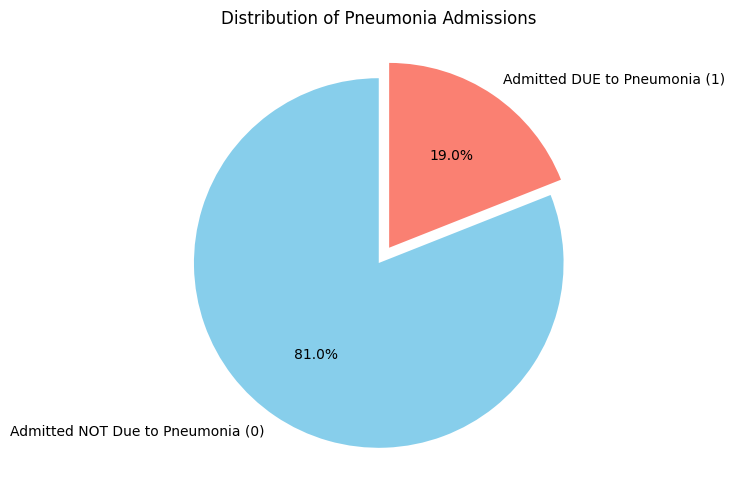

In [13]:
check_distribution(
    dataset,
    TARGET,
    "Distribution of Pneumonia Admissions",
    "Admitted NOT Due to Pneumonia",
    "Admitted DUE to Pneumonia",
)

## Handle missing values

In [14]:
median_imputer = SimpleImputer(strategy="median")
mean_imputer = SimpleImputer(strategy="mean")

In [15]:
# X but only with int columns
X_ints = X[
    [int_feat for int_feat in list(X.columns.values) if int_feat not in FLOAT_FEATURES]
]

In [16]:
X_ints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   age                     1300 non-null   Int64
 1   sex                     1300 non-null   Int64
 2   fatigue                 1300 non-null   Int64
 3   cough_phlegm            1300 non-null   Int64
 4   chronic_resp_disease    1300 non-null   Int64
 5   chronic_kidney_disease  1300 non-null   Int64
 6   heart_failure           1300 non-null   Int64
 7   cancer                  1300 non-null   Int64
 8   systoic_bp              1300 non-null   Int64
 9   dias_bp                 1300 non-null   Int64
 10  pulse_rate              1300 non-null   Int64
 11  resp_rate               1300 non-null   Int64
 12  diabetes_mellitus       1300 non-null   Int64
 13  hemoglobin              1273 non-null   Int64
 14  platelets               1264 non-null   Int64
 15  cough                

In [17]:
median_imputer.fit(X_ints)

SimpleImputer(strategy='median')

In [18]:
median_imputer.statistics_

array([ 53.,   0.,   1.,   0.,   0.,   0.,   0.,   0., 120.,  80.,  89.,
        21.,   0., 122., 276.,   0.])

In [19]:
X_train_ints = X_train[
    [
        int_feat
        for int_feat in list(X_train.columns.values)
        if int_feat not in FLOAT_FEATURES
    ]
]

In [20]:
X_train_ints.info()

<class 'pandas.core.frame.DataFrame'>
Index: 910 entries, 777 to 1126
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   age                     910 non-null    Int64
 1   sex                     910 non-null    Int64
 2   fatigue                 910 non-null    Int64
 3   cough_phlegm            910 non-null    Int64
 4   chronic_resp_disease    910 non-null    Int64
 5   chronic_kidney_disease  910 non-null    Int64
 6   heart_failure           910 non-null    Int64
 7   cancer                  910 non-null    Int64
 8   systoic_bp              910 non-null    Int64
 9   dias_bp                 910 non-null    Int64
 10  pulse_rate              910 non-null    Int64
 11  resp_rate               910 non-null    Int64
 12  diabetes_mellitus       910 non-null    Int64
 13  hemoglobin              890 non-null    Int64
 14  platelets               884 non-null    Int64
 15  cough                   9

In [21]:
X_train_ints_transformed = median_imputer.transform(X_train_ints)

In [22]:
X_train_ints = pd.DataFrame(
    X_train_ints_transformed, columns=X_train_ints.columns, index=X_train_ints.index
)

In [23]:
X_train_ints.info()

<class 'pandas.core.frame.DataFrame'>
Index: 910 entries, 777 to 1126
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     910 non-null    float64
 1   sex                     910 non-null    float64
 2   fatigue                 910 non-null    float64
 3   cough_phlegm            910 non-null    float64
 4   chronic_resp_disease    910 non-null    float64
 5   chronic_kidney_disease  910 non-null    float64
 6   heart_failure           910 non-null    float64
 7   cancer                  910 non-null    float64
 8   systoic_bp              910 non-null    float64
 9   dias_bp                 910 non-null    float64
 10  pulse_rate              910 non-null    float64
 11  resp_rate               910 non-null    float64
 12  diabetes_mellitus       910 non-null    float64
 13  hemoglobin              910 non-null    float64
 14  platelets               910 non-null    floa

In [24]:
# X but only with float columns
X_floats = X[
    [
        float_feat
        for float_feat in list(X.columns.values)
        if float_feat in FLOAT_FEATURES
    ]
]

In [25]:
X_floats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        1300 non-null   float64
 1   hematocrit  1273 non-null   float64
 2   rbc         1273 non-null   float64
 3   wbc         1273 non-null   float64
dtypes: float64(4)
memory usage: 40.8 KB


In [26]:
mean_imputer.fit(X_floats)

SimpleImputer()

In [27]:
mean_imputer.statistics_

array([36.52756923,  0.35734485,  4.08697565, 11.23984289])

In [28]:
X_train_floats = X_train[
    [
        float_feat
        for float_feat in list(X_train.columns.values)
        if float_feat in FLOAT_FEATURES
    ]
]

In [29]:
X_train_floats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 910 entries, 777 to 1126
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        910 non-null    float64
 1   hematocrit  890 non-null    float64
 2   rbc         890 non-null    float64
 3   wbc         890 non-null    float64
dtypes: float64(4)
memory usage: 35.5 KB


In [30]:
X_train_floats_transformed = mean_imputer.transform(X_train_floats)

In [31]:
X_train_floats = pd.DataFrame(
    X_train_floats_transformed,
    columns=X_train_floats.columns,
    index=X_train_floats.index,
)

In [32]:
X_train_floats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 910 entries, 777 to 1126
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        910 non-null    float64
 1   hematocrit  910 non-null    float64
 2   rbc         910 non-null    float64
 3   wbc         910 non-null    float64
dtypes: float64(4)
memory usage: 35.5 KB


In [33]:
X_train = pd.concat([X_train_ints, X_train_floats], axis=1)

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 910 entries, 777 to 1126
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     910 non-null    float64
 1   sex                     910 non-null    float64
 2   fatigue                 910 non-null    float64
 3   cough_phlegm            910 non-null    float64
 4   chronic_resp_disease    910 non-null    float64
 5   chronic_kidney_disease  910 non-null    float64
 6   heart_failure           910 non-null    float64
 7   cancer                  910 non-null    float64
 8   systoic_bp              910 non-null    float64
 9   dias_bp                 910 non-null    float64
 10  pulse_rate              910 non-null    float64
 11  resp_rate               910 non-null    float64
 12  diabetes_mellitus       910 non-null    float64
 13  hemoglobin              910 non-null    float64
 14  platelets               910 non-null    floa

Since the `X_train`'s arrangement of columns changed, we need to also change `X_test`.

In [35]:
X_test_ints = X_test[
    [
        int_feat
        for int_feat in list(X_test.columns.values)
        if int_feat not in FLOAT_FEATURES
    ]
]
X_test_floats = X_test[
    [
        float_feat
        for float_feat in list(X_test.columns.values)
        if float_feat in FLOAT_FEATURES
    ]
]
X_test = pd.concat([X_test_ints, X_test_floats], axis=1)

In [36]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 478 to 718
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     390 non-null    Int64  
 1   sex                     390 non-null    Int64  
 2   fatigue                 390 non-null    Int64  
 3   cough_phlegm            390 non-null    Int64  
 4   chronic_resp_disease    390 non-null    Int64  
 5   chronic_kidney_disease  390 non-null    Int64  
 6   heart_failure           390 non-null    Int64  
 7   cancer                  390 non-null    Int64  
 8   systoic_bp              390 non-null    Int64  
 9   dias_bp                 390 non-null    Int64  
 10  pulse_rate              390 non-null    Int64  
 11  resp_rate               390 non-null    Int64  
 12  diabetes_mellitus       390 non-null    Int64  
 13  hemoglobin              383 non-null    Int64  
 14  platelets               380 non-null    Int64

In [37]:
for f in list(X_test.columns):
    X_test[f] = X_test[f].astype("float64")

In [38]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 478 to 718
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     390 non-null    float64
 1   sex                     390 non-null    float64
 2   fatigue                 390 non-null    float64
 3   cough_phlegm            390 non-null    float64
 4   chronic_resp_disease    390 non-null    float64
 5   chronic_kidney_disease  390 non-null    float64
 6   heart_failure           390 non-null    float64
 7   cancer                  390 non-null    float64
 8   systoic_bp              390 non-null    float64
 9   dias_bp                 390 non-null    float64
 10  pulse_rate              390 non-null    float64
 11  resp_rate               390 non-null    float64
 12  diabetes_mellitus       390 non-null    float64
 13  hemoglobin              383 non-null    float64
 14  platelets               380 non-null    float

In [39]:
CATEG_FEATURES = [3, 4, 5, 6, 7, 12, 15]

## Training

### RF + Active SMOTE

`RfActiveSMOTE` combines `ActiveSMOTE` and `RandomForestClassifier`. The training undergoes several `N_ITERATIONS` (defined in [Bootstrap](#Bootstrap)) that will generate synthetic samples to balance the dataset. A brief overview `model.train(n_iterations: int)`'s implementation (can be accessed at
`pneumonia_predictor/backend/rf_active_smote.py`):
```python
RfActiveSMOTE.train(n_iterations: int):
    RfActiveSMOTE.fit_classifier()
    ActiveSMOTE.probabilities = RfActiveSMOTE.classifier.predict_proba(X_train)
    for i in range(n_iterations):
        ActiveSMOTE.uncertainty_sampling()
        ActiveSMOTE.diversity_sampling()
        ActiveSMOTE.create_synthetic_samples(sampling_ratio)
        concat(total_synthetic_samples, current_synthetic_samples)
        RfActiveSMOTE.fit_classifier()
```

The `ActiveSMOTE` implementation can be accessed at `pneumonia_predictor/backend/active_smote.py`.

In [40]:
rf_active_smote = RfActiveSMOTE(
    X_train, y_train, X_test, y_test, TARGET, CATEG_FEATURES
)

In [41]:
rf_active_smote.train()

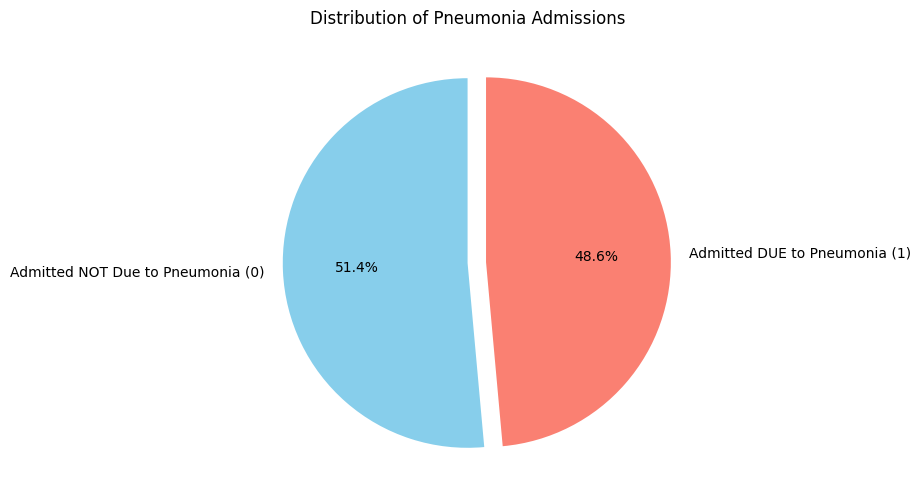

In [42]:
check_distribution(
    rf_active_smote.y_train_resampled,
    TARGET,
    "Distribution of Pneumonia Admissions",
    "Admitted NOT Due to Pneumonia",
    "Admitted DUE to Pneumonia",
)

# RF + SMOTE

In [43]:
rf_smote = RfSMOTE(X_train, y_train, X_test, y_test, TARGET, CATEG_FEATURES)

In [44]:
rf_smote.train()

## Experiment

In [45]:
tester = ModelTester(rf_smote, rf_active_smote)

In [46]:
tester.run_tests(10)

In [47]:
tester.model_a_res  # RF SMOTE

,Test,accuracy,precision,recall,f1-score,Average
0,1,0.897436,0.891633,0.897436,0.891273,0.894444
1,2,0.907692,0.903391,0.907692,0.902145,0.905230
2,3,0.900000,0.895292,0.900000,0.891905,0.896799
3,4,0.902564,0.897666,0.902564,0.898194,0.900247
4,5,0.897436,0.891738,0.897436,0.892070,0.894670
5,6,0.910256,0.908708,0.910256,0.902189,0.907852
6,7,0.900000,0.894708,0.900000,0.895145,0.897463
7,8,0.920513,0.917452,0.920513,0.917236,0.918928
8,9,0.905128,0.900555,0.905128,0.899047,0.902465
9,10,0.905128,0.902062,0.905128,0.903145,0.903866


In [48]:
tester.model_b_res  # RF-Active SMOTE

,Test,accuracy,precision,recall,f1-score,Average
0,1,0.938462,0.936761,0.908795,0.921876,0.926473
1,2,0.945641,0.946361,0.925446,0.935396,0.938211
2,3,0.945641,0.952066,0.918750,0.934023,0.937620
3,4,0.943077,0.944964,0.917188,0.930084,0.933828
4,5,0.940513,0.941731,0.911161,0.925280,0.929671
5,6,0.944103,0.948341,0.916696,0.931434,0.935144
6,7,0.942051,0.944117,0.914330,0.928092,0.932148
7,8,0.946154,0.955011,0.916830,0.934364,0.938090
8,9,0.939487,0.941610,0.907188,0.922934,0.927805
9,10,0.940000,0.943509,0.906384,0.923380,0.928318


In [49]:
tester.compare_res

,Metrics,t-value,p-value
0,accuracy,-20.453387,7.450083e-09
1,precision,-24.528692,1.490798e-09
2,recall,-3.978319,3.213957e-03
3,f1-score,-12.802229,4.428824e-07


### Confusion Matrix for RF + Active SMOTE

In [50]:
y_rf_asmote_pred = rf_active_smote.classifier.predict(X_test)
cm_rf_asmote = confusion_matrix(y_test, y_rf_asmote_pred)

In [51]:
cm_rf_asmote_disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf_asmote, display_labels=rf_active_smote.classifier.classes_
)

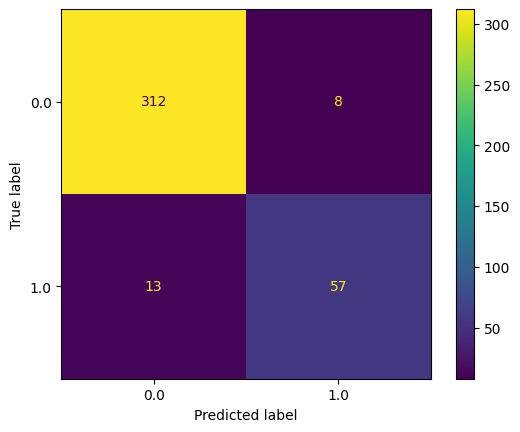

In [52]:
cm_rf_asmote_disp.plot()

### Confusion Matrix for RF + SMOTE

In [53]:
y_rfsmote_pred = rf_smote.classifier.predict(X_test)
cm_rfsmote = confusion_matrix(y_test, y_rfsmote_pred)

In [54]:
cm_rfsmote_disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rfsmote, display_labels=rf_smote.classifier.classes_
)

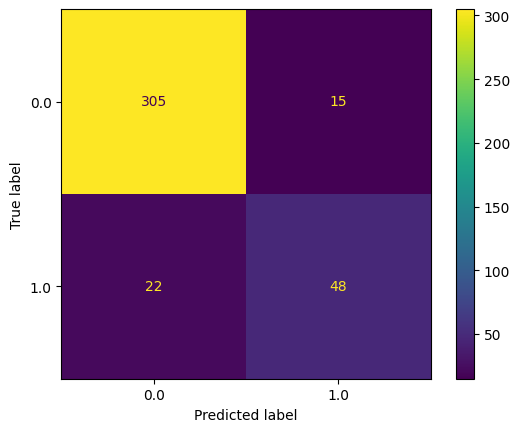

In [55]:
cm_rfsmote_disp.plot()

## Feature importance

For RF-ActiveSMOTE:

In [56]:
feature_names = [
    "age",
    "sex",
    "fatigue",
    "cough_phlegm",
    "chronic_resp_disease",
    "chronic_kidney_disease",
    "heart_failure",
    "cancer",
    "systoic_bp",
    "dias_bp",
    "pulse_rate",
    "resp_rate",
    "diabetes_mellitus",
    "hemoglobin",
    "platelets",
    "cough",
    "temp",
    "hematocrit",
    "rbc",
    "wbc",
]

In [57]:
start_time = time.time()
importances = rf_active_smote.classifier.feature_importances_
rf_active_smote_std = np.std(
    [tree.feature_importances_ for tree in rf_active_smote.classifier.estimators_],
    axis=0,
)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.102 seconds


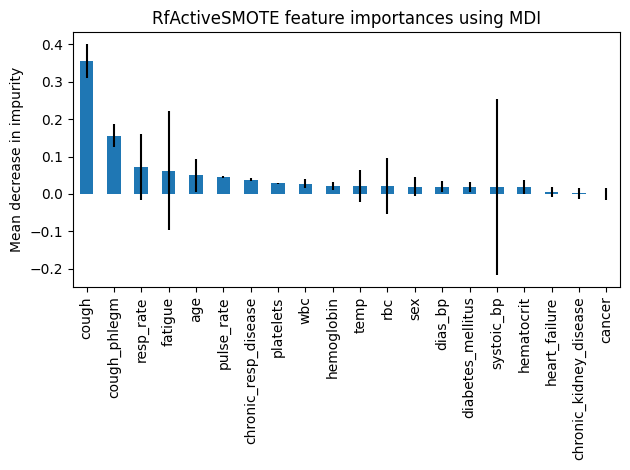

In [58]:
rf_active_smote_importances = pd.Series(importances, index=feature_names).sort_values(
    ascending=False
)

fig, ax = plt.subplots()
rf_active_smote_importances.plot.bar(yerr=rf_active_smote_std, ax=ax)
ax.set_title("RfActiveSMOTE feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [59]:
pd.Series(importances, index=feature_names).sort_values(ascending=False)

cough                     0.356169
cough_phlegm              0.155754
resp_rate                 0.071608
fatigue                   0.062251
age                       0.049677
pulse_rate                0.045247
chronic_resp_disease      0.037801
platelets                 0.028438
wbc                       0.027622
hemoglobin                0.021770
temp                      0.021318
rbc                       0.020578
sex                       0.019772
dias_bp                   0.019501
diabetes_mellitus         0.019216
systoic_bp                0.018650
hematocrit                0.018293
heart_failure             0.004266
chronic_kidney_disease    0.001979
cancer                    0.000091
dtype: float64

For RF + SMOTE

In [60]:
start_time = time.time()
importances = rf_smote.classifier.feature_importances_
rf_smote_std = np.std(
    [tree.feature_importances_ for tree in rf_smote.classifier.estimators_], axis=0
)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.003 seconds


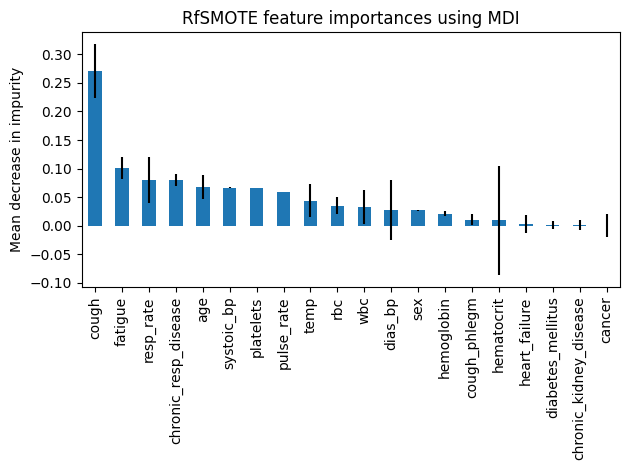

In [61]:
rf_smote_importances = pd.Series(importances, index=feature_names).sort_values(
    ascending=False
)

fig, ax = plt.subplots()
rf_smote_importances.plot.bar(yerr=rf_smote_std, ax=ax)
ax.set_title("RfSMOTE feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [62]:
pd.Series(importances, index=feature_names).sort_values(ascending=False)

cough                     0.271378
fatigue                   0.100717
resp_rate                 0.080542
chronic_resp_disease      0.080441
age                       0.067095
systoic_bp                0.066639
platelets                 0.065418
pulse_rate                0.058202
temp                      0.043618
rbc                       0.035251
wbc                       0.032202
dias_bp                   0.027162
sex                       0.026555
hemoglobin                0.021202
cough_phlegm              0.010549
hematocrit                0.009035
heart_failure             0.002442
diabetes_mellitus         0.000805
chronic_kidney_disease    0.000746
cancer                    0.000000
dtype: float64

In [63]:
# rf_active_smote.save("pneumonia_predictor")

In [64]:
# rf_smote.save("pneumonia_predictor_rfsmote")